# Klasyfikacja algorytmem k-najbliższych sąsiadów

## Wczytanie danych

In [1]:
# Imports, data loading
from sklearn.model_selection import LeaveOneOut, cross_val_score, StratifiedKFold, KFold, train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris, load_wine
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import io

def load_glass_data():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data"

    col_names = ['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type']
    glass_data = pd.read_csv(url, names=col_names, index_col='Id')
    X = glass_data.drop('Type', axis=1)
    y = glass_data['Type']
    return X, y

def load_dataset(dataset_name):
    if dataset_name == 'IRIS':
        data = load_iris()
        X, y = data.data, data.target
    elif dataset_name == 'WINE':
        data = load_wine()
        X, y = data.data, data.target
    elif dataset_name == 'GLASS':
        X, y = load_glass_data()
    else:
        return "Nieznany zbiór danych"

    return X, y

## Eksperyment k-NN dla wszystkich zbiorów danych


Moja waga:

$ \text{waga} = \frac{1}{\text{odległość}^2} $


In [2]:
def weighted_by_distance(distances):
    """ Custom weight function: weights are inverse square of the distance """
    # Prevent division by zero
    with np.errstate(divide='ignore'):
        return 1.0 / distances**2

def k_nn_experiment_with_confusion_matrix(dataset_name, k_values, voting_methods, distance_metrics, folds, shuffle=True):
    results = []
    confusion_matrices = []
    X, y = load_dataset(dataset_name)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    for k in k_values:
        for voting in voting_methods:
            for distance in distance_metrics:
                clf = KNeighborsClassifier(n_neighbors=k, weights=voting, metric=distance)
                if folds > 1:
                    cv = StratifiedKFold(n_splits=folds, shuffle=shuffle) if dataset_name != 'GLASS' else KFold(n_splits=folds, shuffle=shuffle)
                    scores = cross_val_score(clf, X_scaled, y, cv=cv, scoring='accuracy')
                    f1 = cross_val_score(clf, X_scaled, y, cv=cv, scoring='f1_weighted')
                    cm = confusion_matrix(y, clf.fit(X_scaled, y).predict(X_scaled))
                    confusion_matrices.append((dataset_name, k, voting, distance, cm))
                    results.append((dataset_name, k, voting, distance, folds, scores.mean(), f1.mean()))
                else:
                    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
                    clf.fit(X_train, y_train)
                    y_pred = clf.predict(X_test)
                    accuracy = accuracy_score(y_test, y_pred)
                    f1 = precision_recall_fscore_support(y_test, y_pred, average='weighted')[2]
                    cm = confusion_matrix(y_test, y_pred)
                    confusion_matrices.append((dataset_name, k, voting, distance, cm))
                    results.append((dataset_name, k, voting, distance, folds, accuracy, f1))
    return results, confusion_matrices

k_values = [1, 2, 5, 6, 7, 8, 10, 11, 15]
voting_methods = ['uniform', 'distance', weighted_by_distance]
distance_metrics = ['euclidean', 'manhattan', 'minkowski', 'chebyshev']
folds = 5
datasets = ['IRIS', 'WINE', 'GLASS']
all_results, all_conf_matrices = [], []
for dataset in datasets:
    results, conf_matrices = k_nn_experiment_with_confusion_matrix(dataset, k_values, voting_methods, distance_metrics, folds)
    all_results.extend(results)
    all_conf_matrices.extend(conf_matrices)

results_df = pd.DataFrame(all_results, columns=['Dataset', 'K', 'Voting', 'Distance', 'Folds', 'Accuracy', 'F1'])
print("Zakończono wszystkie eksperymenty:")
print(results_df)

Zakończono wszystkie eksperymenty:
    Dataset   K                                          Voting   Distance  \
0      IRIS   1                                         uniform  euclidean   
1      IRIS   1                                         uniform  manhattan   
2      IRIS   1                                         uniform  minkowski   
3      IRIS   1                                         uniform  chebyshev   
4      IRIS   1                                        distance  euclidean   
..      ...  ..                                             ...        ...   
319   GLASS  15                                        distance  chebyshev   
320   GLASS  15  <function weighted_by_distance at 0x17d3ee950>  euclidean   
321   GLASS  15  <function weighted_by_distance at 0x17d3ee950>  manhattan   
322   GLASS  15  <function weighted_by_distance at 0x17d3ee950>  minkowski   
323   GLASS  15  <function weighted_by_distance at 0x17d3ee950>  chebyshev   

     Folds  Accuracy        

### Macierze pomyłek

In [3]:
print("\nMacierze pomyłek:")

for i, conf_matrix in enumerate(all_conf_matrices):
    dataset, k, voting, distance, cm = conf_matrix
    print(f"Macierz pomyłek {i+1} dla zbioru {dataset}, k={k}, metoda głosowania={voting}, metryka={distance}:")
    print(cm)


Macierze pomyłek:
Macierz pomyłek 1 dla zbioru IRIS, k=1, metoda głosowania=uniform, metryka=euclidean:
[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]
Macierz pomyłek 2 dla zbioru IRIS, k=1, metoda głosowania=uniform, metryka=manhattan:
[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]
Macierz pomyłek 3 dla zbioru IRIS, k=1, metoda głosowania=uniform, metryka=minkowski:
[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]
Macierz pomyłek 4 dla zbioru IRIS, k=1, metoda głosowania=uniform, metryka=chebyshev:
[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]
Macierz pomyłek 5 dla zbioru IRIS, k=1, metoda głosowania=distance, metryka=euclidean:
[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]
Macierz pomyłek 6 dla zbioru IRIS, k=1, metoda głosowania=distance, metryka=manhattan:
[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]
Macierz pomyłek 7 dla zbioru IRIS, k=1, metoda głosowania=distance, metryka=minkowski:
[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]
Macierz pomyłek 8 dla zbioru IRIS, k=1, metoda głosowania=distance, metryka=chebyshev:
[[50  0  0]
 [ 0 50  0]
 [ 0  

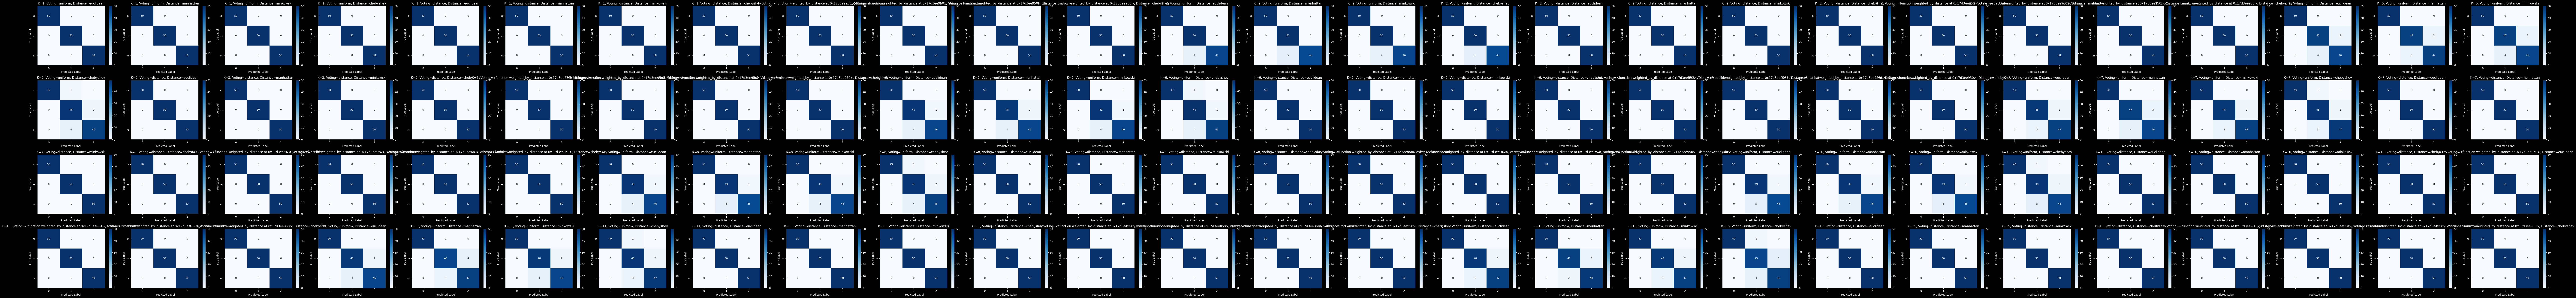

In [4]:
def plot_all_confusion_matrices(all_conf_matrices, dataset):
    num_matrices = len([cm for cm in all_conf_matrices if cm[0] == dataset])
    rows = 4
    cols = (num_matrices + rows - 1) // rows
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), squeeze=False)
    
    matrix_idx = 0
    for i, ax in enumerate(axes.flat):
        if matrix_idx < num_matrices:
            conf_matrix = all_conf_matrices[matrix_idx]
            if conf_matrix[0] == dataset:
                sns.heatmap(conf_matrix[4], annot=True, fmt="d", cmap='Blues', ax=ax)
                ax.set_title(f"K={conf_matrix[1]}, Voting={conf_matrix[2]}, Distance={conf_matrix[3]}")
                ax.set_xlabel('Predicted Label')
                ax.set_ylabel('True Label')
                matrix_idx += 1
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_all_confusion_matrices(all_conf_matrices, 'IRIS')

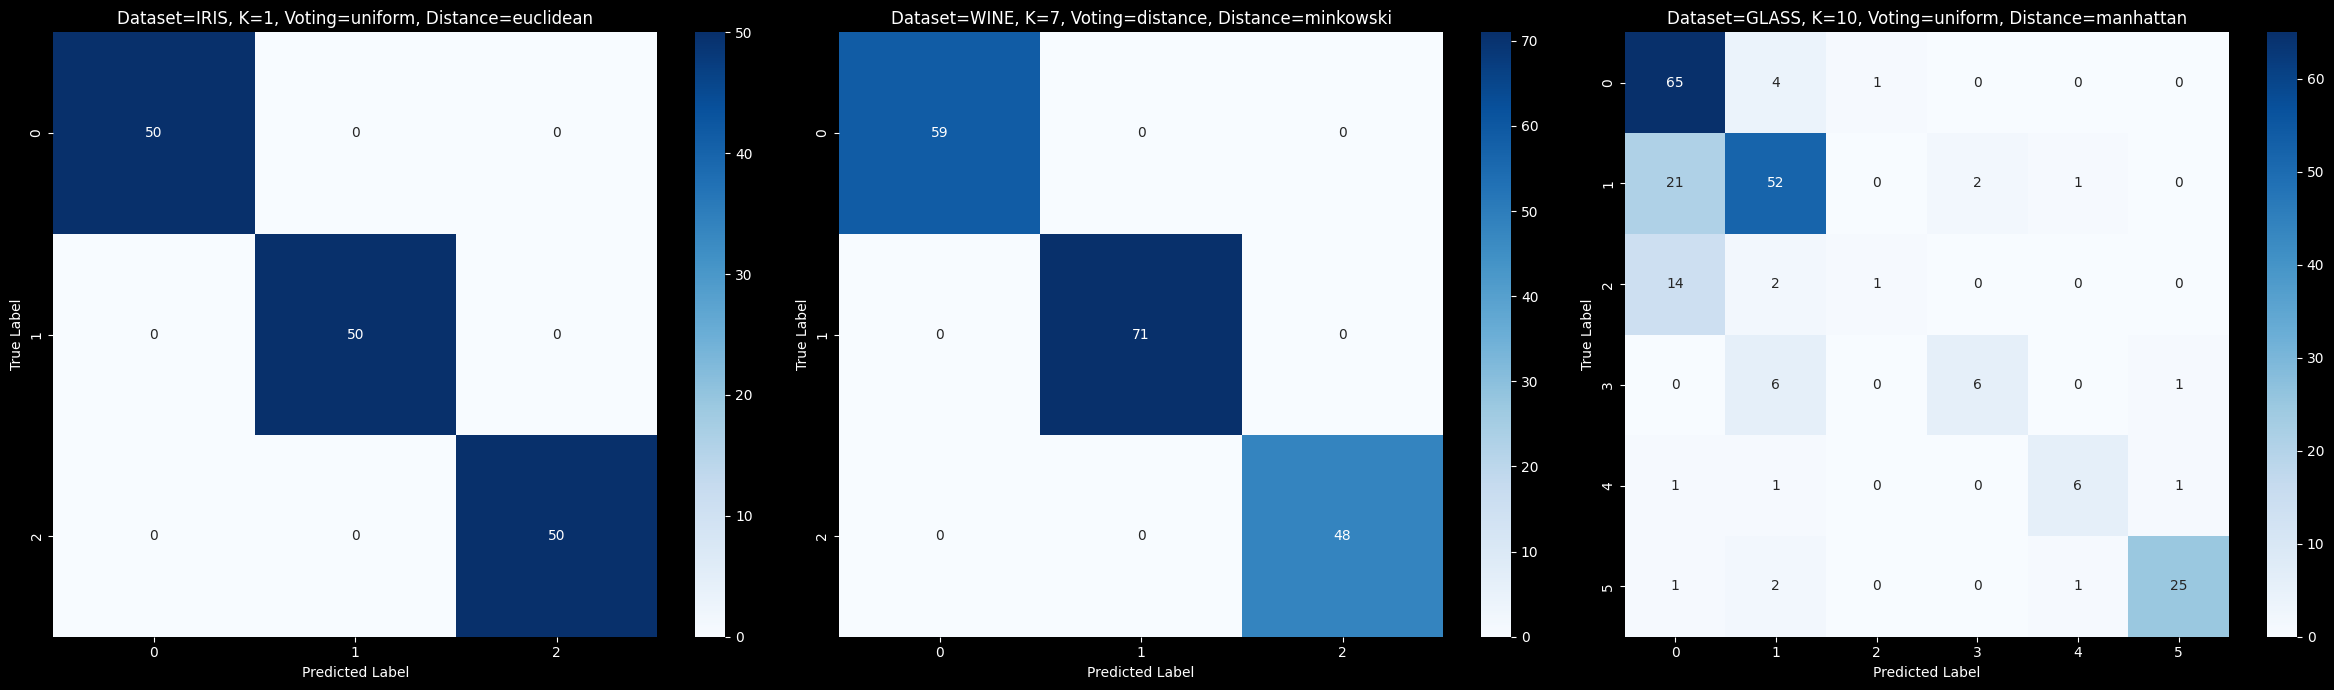

In [5]:
def plot_selected_confusion_matrices(all_conf_matrices, selected_indices):
    num_matrices = len(selected_indices)
    cols = 3
    fig, axes = plt.subplots(1, cols, figsize=(cols * 8, 7), squeeze=False)
    
    for idx, ax in enumerate(axes.flat):
        if idx < num_matrices:
            conf_matrix = all_conf_matrices[selected_indices[idx]]
            sns.heatmap(conf_matrix[4], annot=True, fmt="d", cmap='Blues', ax=ax)
            ax.set_title(f"Dataset={conf_matrix[0]}, K={conf_matrix[1]}, Voting={conf_matrix[2]}, Distance={conf_matrix[3]}")
            ax.set_xlabel('Predicted Label')
            ax.set_ylabel('True Label')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
plot_selected_confusion_matrices(all_conf_matrices, [0, 162, 289])


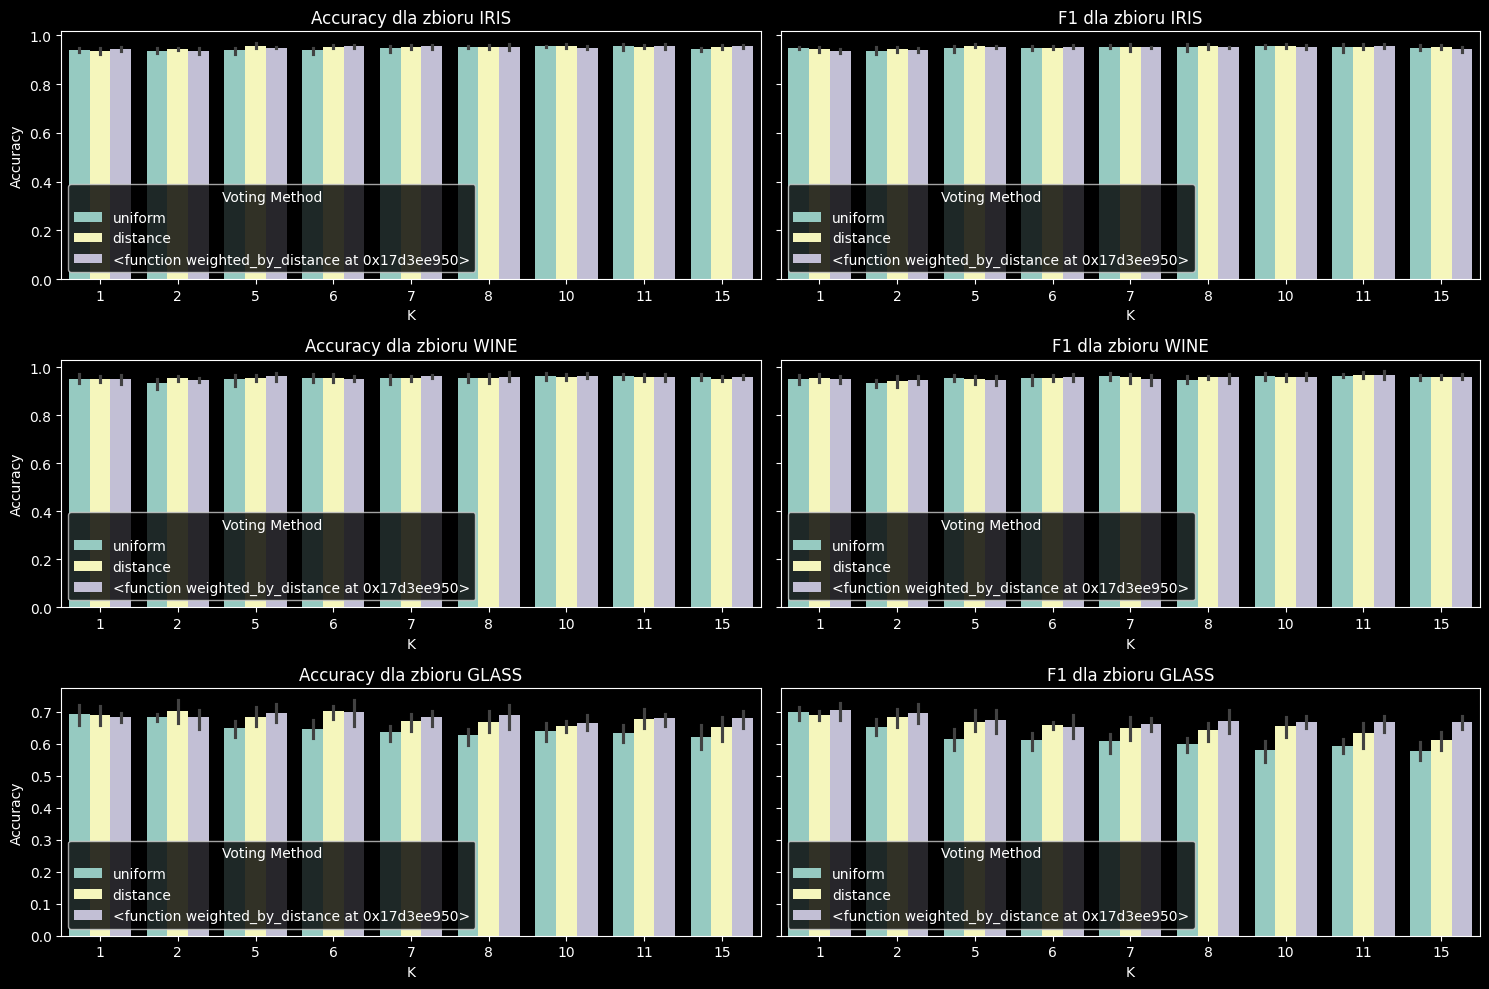

In [6]:
datasets = results_df['Dataset'].unique()
metrics = ["Accuracy", "F1"]

fig, axes = plt.subplots(len(datasets), len(metrics), figsize=(15, 10), sharey='row')
for i, dataset in enumerate(datasets):
    for j, metric in enumerate(metrics):
        sns.barplot(x='K', y=metric, hue='Voting', data=results_df[results_df['Dataset'] == dataset], ax=axes[i][j])
        axes[i][j].set_title(f'{metric} dla zbioru {dataset}')
        axes[i][j].legend(title='Voting Method')

plt.tight_layout()
plt.show()

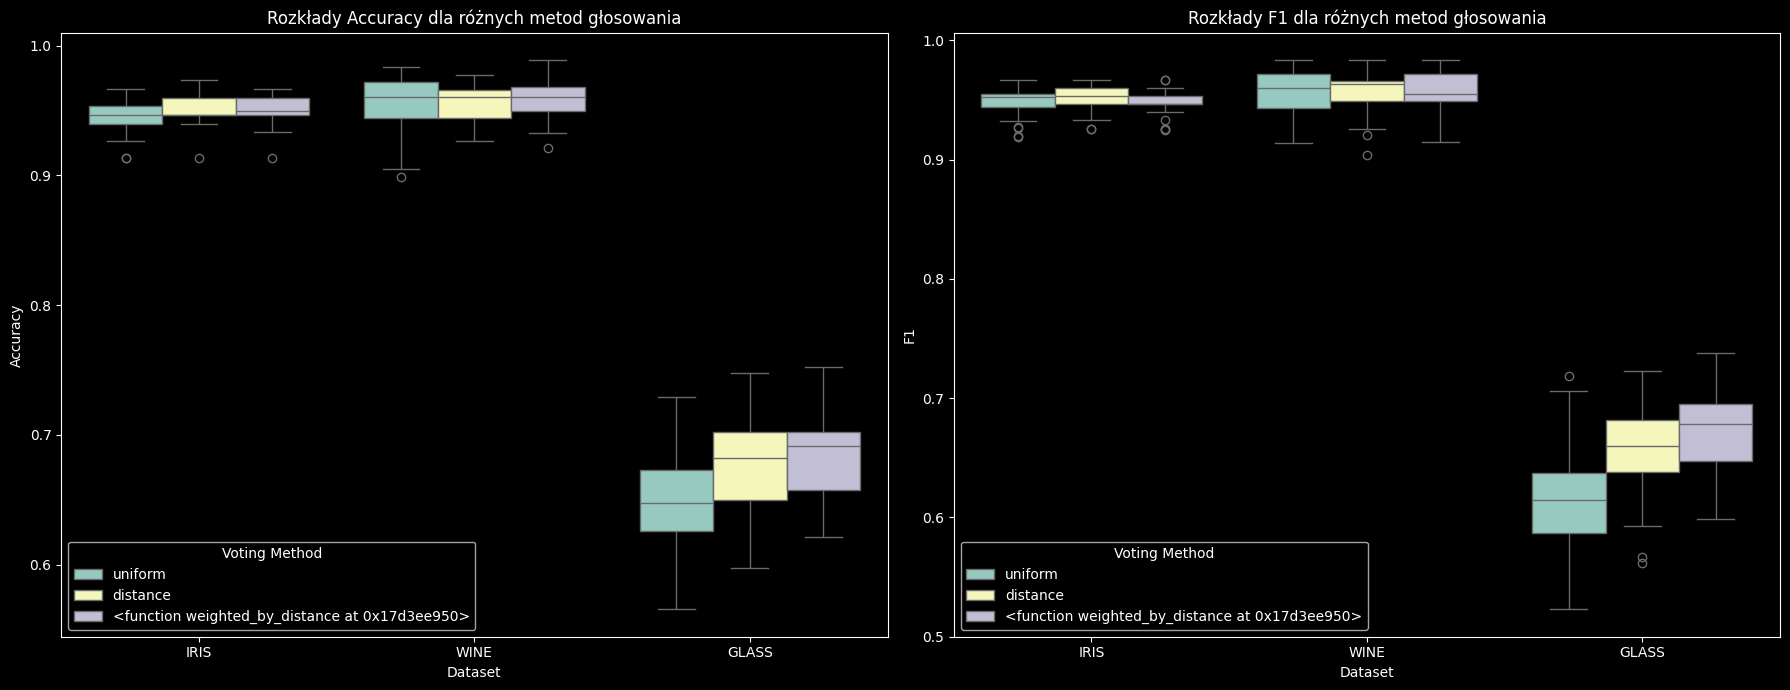

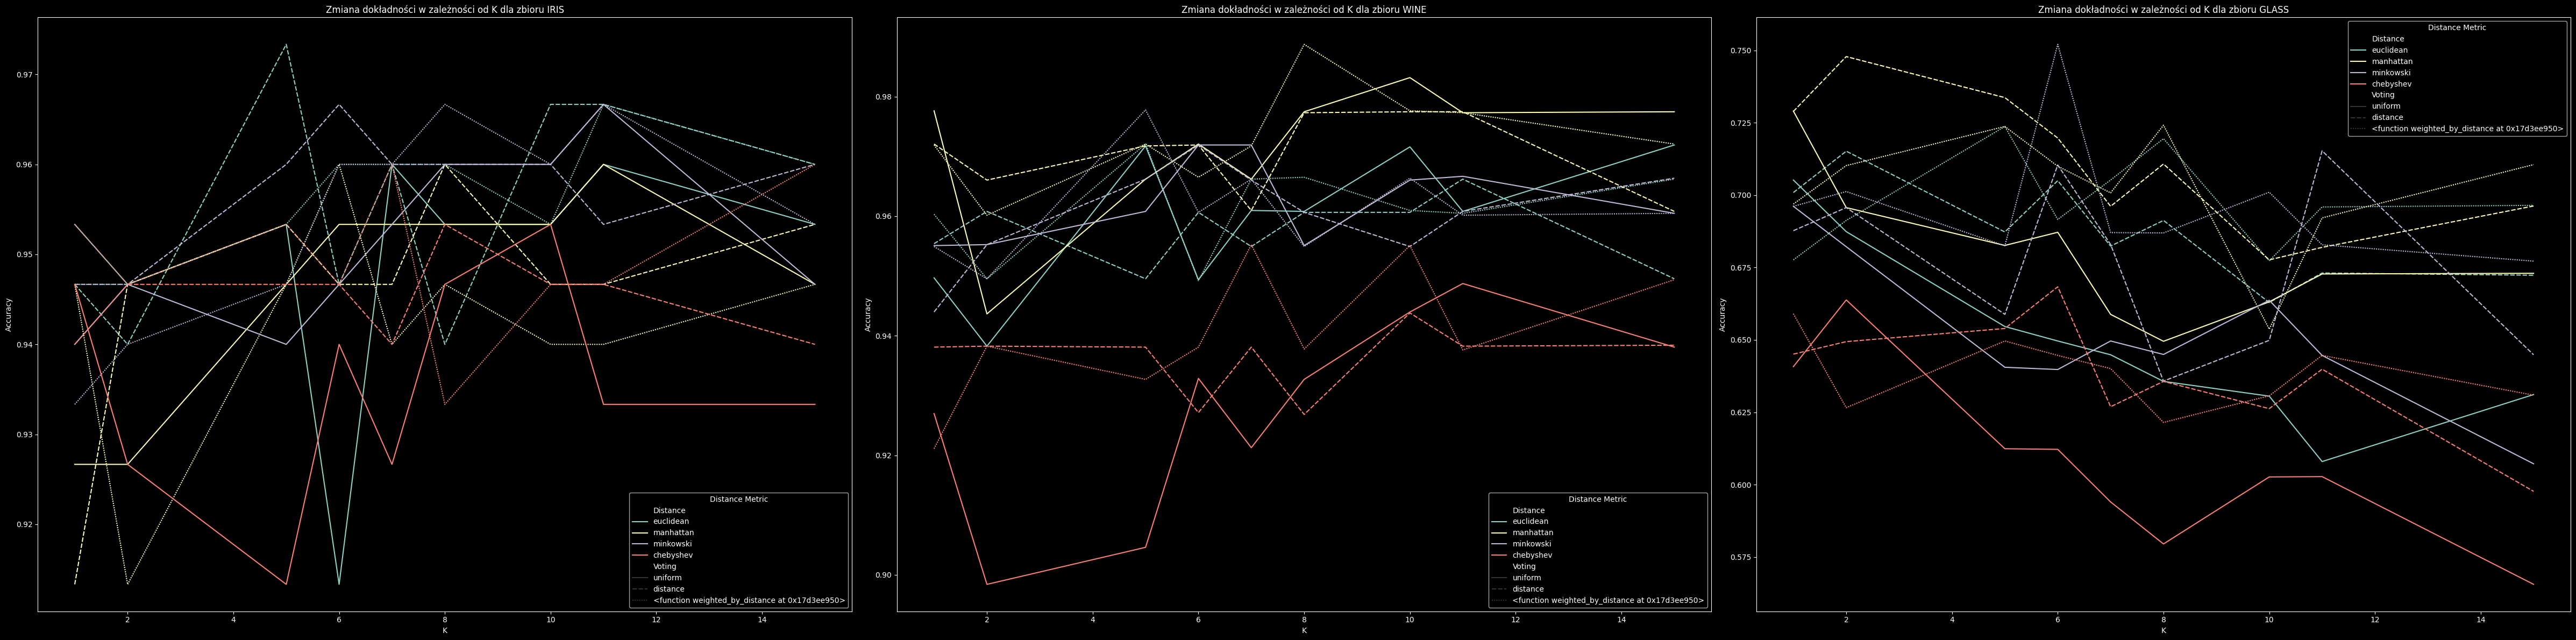

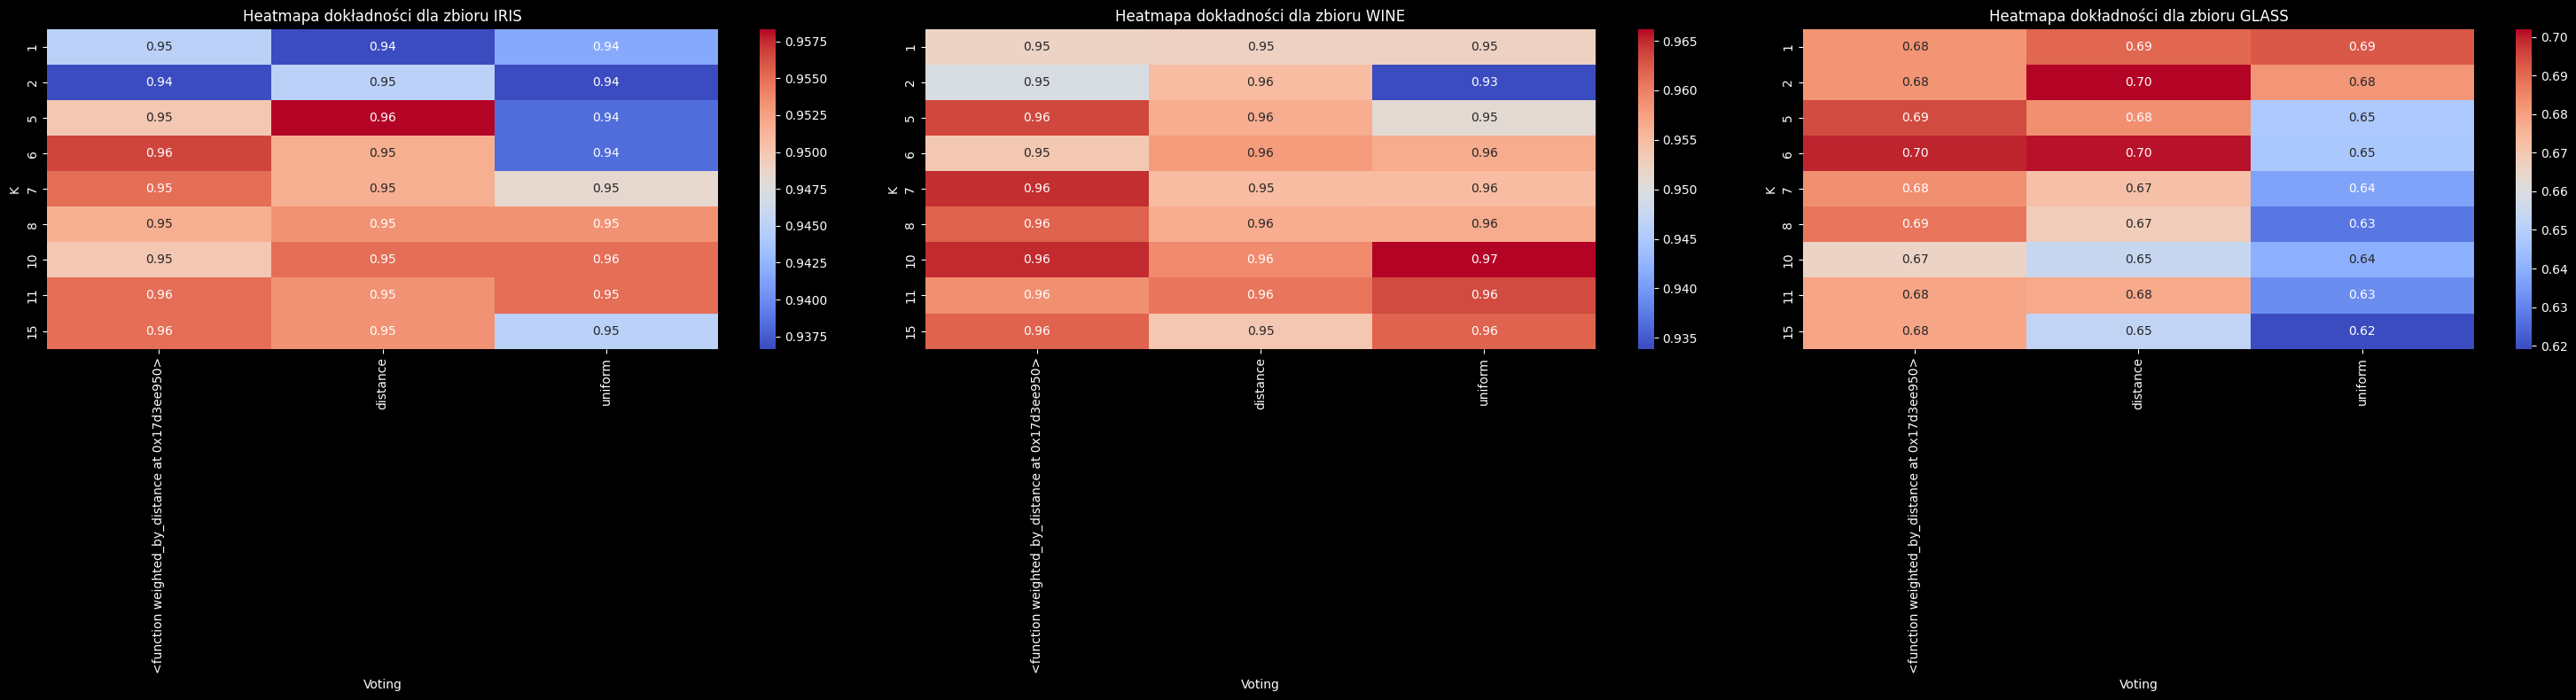

In [7]:
plt.figure(figsize=(18, 7))  # Zwiększona szerokość, aby pomieścić oba wykresy
for i, metric in enumerate(['Accuracy', 'F1']):
    plt.subplot(1, 2, i+1)  # Tworzenie dwóch subplots: 1 wiersz, 2 kolumny, indeks (i+1)
    sns.boxplot(x='Dataset', y=metric, hue='Voting', data=results_df)
    plt.title(f'Rozkłady {metric} dla różnych metod głosowania')
    plt.legend(title='Voting Method')
plt.tight_layout()
plt.show()

datasets = results_df['Dataset'].unique()
plt.figure(figsize=(len(datasets)*16, 12))  # Dostosuj szerokość w zależności od liczby zbiorów danych
for i, dataset in enumerate(datasets):
    plt.subplot(1, len(datasets), i+1)  # Dla każdego zbioru danych tworzy panel
    sns.lineplot(x='K', y='Accuracy', hue='Distance', style='Voting', data=results_df[results_df['Dataset'] == dataset])
    plt.title(f'Zmiana dokładności w zależności od K dla zbioru {dataset}')
    plt.legend(title='Distance Metric')
plt.tight_layout()
plt.show()

plt.figure(figsize=(len(datasets)*10, 8))  # Dostosuj szerokość w zależności od liczby zbiorów danych
for i, dataset in enumerate(datasets):
    plt.subplot(1, len(datasets), i+1)
    pivot_table = results_df[results_df['Dataset'] == dataset].pivot_table(index='K', columns='Voting', values='Accuracy', aggfunc='mean')
    sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Heatmapa dokładności dla zbioru {dataset}')
plt.tight_layout()
plt.show()


## Walidacja krzyżowa - IRIS

In [8]:
def cross_validation_experiment(dataset_name, k_values, voting_methods, distance_metrics, shuffle_options, folds_options, cv_types):
    results = []

    X, y = load_dataset(dataset_name)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    for k in k_values:
        for voting in voting_methods:
            for distance in distance_metrics:
                for shuffle in shuffle_options:
                    for folds in folds_options:
                        for cv_type in cv_types:
                            clf = KNeighborsClassifier(n_neighbors=k, weights=voting, metric=distance)
                            
                            if cv_type == 'standard':
                                cv = KFold(n_splits=folds, shuffle=shuffle)
                            elif cv_type == 'stratified':
                                cv = StratifiedKFold(n_splits=folds, shuffle=shuffle)
                            elif cv_type == 'leave-one-out':
                                cv = LeaveOneOut()
                            else:
                                raise ValueError(f"Unknown cross-validation type: {cv_type}")
                            
                            scores = cross_val_score(clf, X_scaled, y, cv=cv, scoring='accuracy')
                            f1_scores = cross_val_score(clf, X_scaled, y, cv=cv, scoring='f1_weighted')
                            
                            results.append({
                                'Dataset': dataset_name,
                                'K': k,
                                'Voting': voting,
                                'Distance': distance,
                                'Folds': folds,
                                'Shuffle': shuffle,
                                'CV Type': cv_type,
                                'Accuracy Mean': scores.mean(),
                                'F1 Mean': f1_scores.mean(),
                            })
                            # print(f"Zakończono eksperyment dla zbioru {dataset_name}, k={k}, voting={voting}, distance={distance}, shuffle={shuffle}, folds={folds}, cv_type={cv_type}")
    return results

k_values = [7]
voting_methods = ['distance']
distance_metrics = ['euclidean']
shuffle_options = [True, False]
folds_options = [2, 5, 10, 15]
cv_types = ['standard', 'stratified', 'leave-one-out']

datasets = ['IRIS']
all_cross_val_results = []

for dataset in datasets:
    results = cross_validation_experiment(dataset, k_values, voting_methods, distance_metrics, shuffle_options, folds_options, cv_types)
    all_cross_val_results.extend(results)

results_cross_val_df = pd.DataFrame(all_cross_val_results)
print("Zakończono wszystkie eksperymenty:")
print(results_cross_val_df)

Zakończono wszystkie eksperymenty:
   Dataset  K    Voting   Distance  Folds  Shuffle        CV Type  \
0     IRIS  7  distance  euclidean      2     True       standard   
1     IRIS  7  distance  euclidean      2     True     stratified   
2     IRIS  7  distance  euclidean      2     True  leave-one-out   
3     IRIS  7  distance  euclidean      5     True       standard   
4     IRIS  7  distance  euclidean      5     True     stratified   
5     IRIS  7  distance  euclidean      5     True  leave-one-out   
6     IRIS  7  distance  euclidean     10     True       standard   
7     IRIS  7  distance  euclidean     10     True     stratified   
8     IRIS  7  distance  euclidean     10     True  leave-one-out   
9     IRIS  7  distance  euclidean     15     True       standard   
10    IRIS  7  distance  euclidean     15     True     stratified   
11    IRIS  7  distance  euclidean     15     True  leave-one-out   
12    IRIS  7  distance  euclidean      2    False       standard   

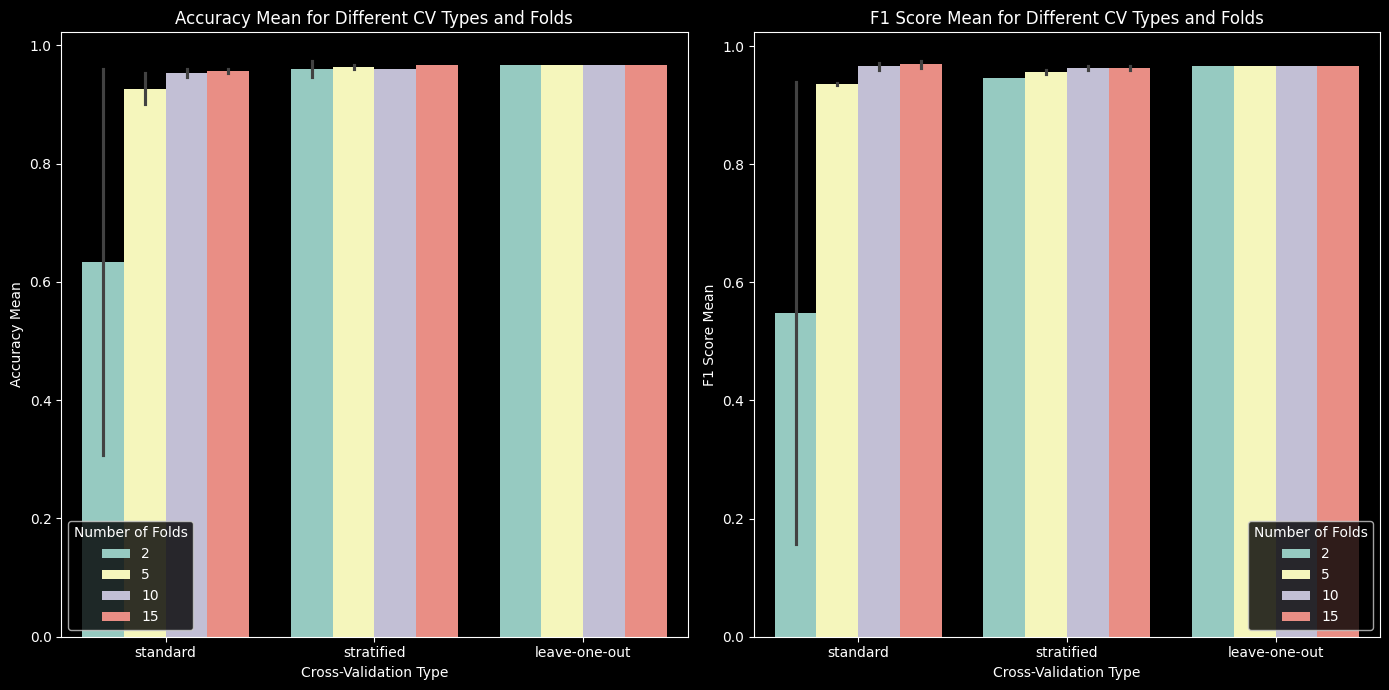

In [9]:
def plot_cross_validation_results(results_df):
    results_df['Folds'] = results_df['Folds'].astype(str)
    results_df['Shuffle'] = results_df['Shuffle'].map({True: 'With Shuffle', False: 'Without Shuffle'})

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    sns.barplot(x='CV Type', y='Accuracy Mean', hue='Folds', data=results_df)
    plt.title('Accuracy Mean for Different CV Types and Folds')
    plt.xlabel('Cross-Validation Type')
    plt.ylabel('Accuracy Mean')
    plt.legend(title='Number of Folds')

    plt.subplot(1, 2, 2)
    sns.barplot(x='CV Type', y='F1 Mean', hue='Folds', data=results_df)
    plt.title('F1 Score Mean for Different CV Types and Folds')
    plt.xlabel('Cross-Validation Type')
    plt.ylabel('F1 Score Mean')
    plt.legend(title='Number of Folds')

    plt.tight_layout()
    plt.show()

plot_cross_validation_results(results_cross_val_df)

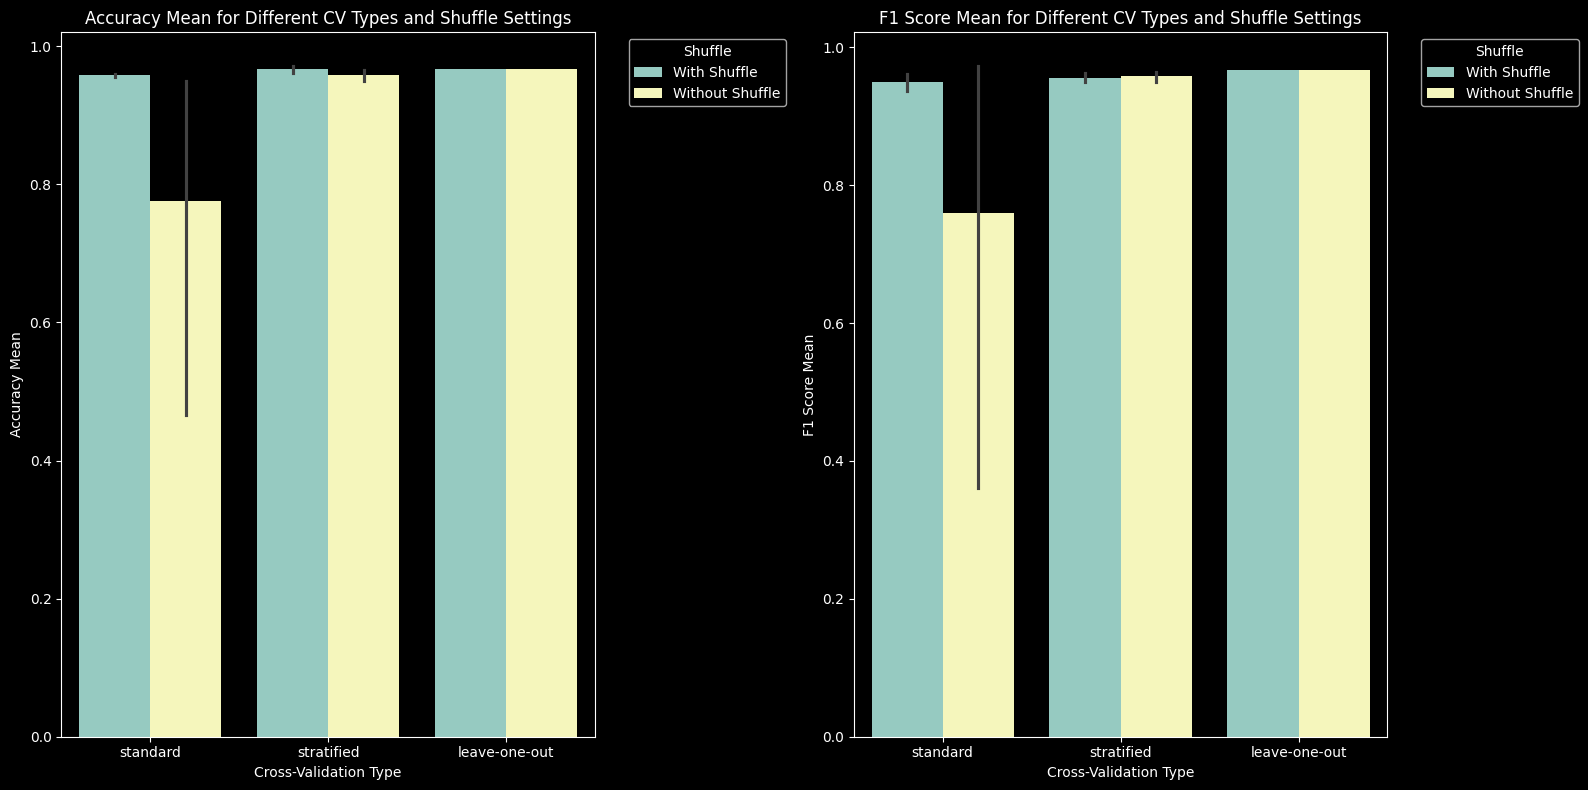

In [10]:
def plot_cross_validation_results_with_shuffle(results_df):
    results_df['Folds'] = results_df['Folds'].astype(str)
    
    results_df['Shuffle'] = results_df['Shuffle'].map({True: 'With Shuffle', False: 'Without Shuffle'})
    
    plt.figure(figsize=(16, 8))
    
    plt.subplot(1, 2, 1)
    sns.barplot(x='CV Type', y='Accuracy Mean', hue='Shuffle', data=results_df)
    plt.title('Accuracy Mean for Different CV Types and Shuffle Settings')
    plt.xlabel('Cross-Validation Type')
    plt.ylabel('Accuracy Mean')
    plt.legend(title='Shuffle', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.subplot(1, 2, 2)
    sns.barplot(x='CV Type', y='F1 Mean', hue='Shuffle', data=results_df)
    plt.title('F1 Score Mean for Different CV Types and Shuffle Settings')
    plt.xlabel('Cross-Validation Type')
    plt.ylabel('F1 Score Mean')
    plt.legend(title='Shuffle', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

results_cross_val_df = pd.DataFrame(all_cross_val_results)
plot_cross_validation_results_with_shuffle(results_cross_val_df)

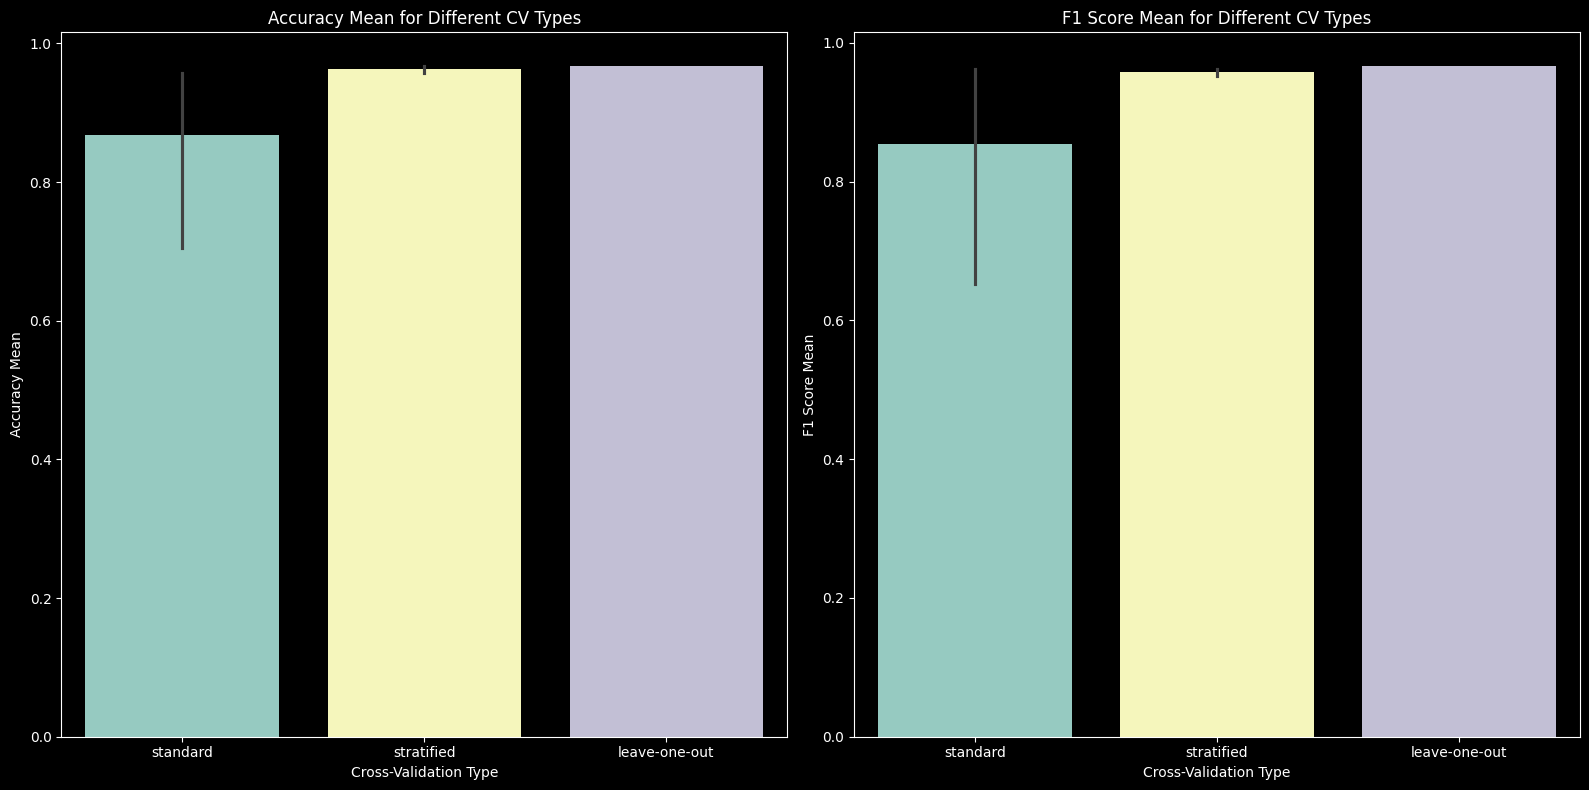

In [11]:
def plot_cross_validation_results_by_cv_type(results_df):
    results_df['Folds'] = results_df['Folds'].astype(str)
    
    results_df['Shuffle'] = results_df['Shuffle'].map({True: 'With Shuffle', False: 'Without Shuffle'})
    
    plt.figure(figsize=(16, 8))
    
    plt.subplot(1, 2, 1)
    sns.barplot(x='CV Type', y='Accuracy Mean', hue='CV Type', data=results_df)
    plt.title('Accuracy Mean for Different CV Types')
    plt.xlabel('Cross-Validation Type')
    plt.ylabel('Accuracy Mean')

    plt.subplot(1, 2, 2)
    sns.barplot(x='CV Type', y='F1 Mean', hue='CV Type', data=results_df)
    plt.title('F1 Score Mean for Different CV Types')
    plt.xlabel('Cross-Validation Type')
    plt.ylabel('F1 Score Mean')
    
    plt.tight_layout()
    plt.show()

results_cross_val_df = pd.DataFrame(all_cross_val_results)
plot_cross_validation_results_by_cv_type(results_cross_val_df)

## Walidacja krzyżowa - GLASS

In [12]:
def cross_validation_experiment(dataset_name, k_values, voting_methods, distance_metrics, shuffle_options, folds_options, cv_types):
    results = []

    X, y = load_dataset(dataset_name)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    for k in k_values:
        for voting in voting_methods:
            for distance in distance_metrics:
                for shuffle in shuffle_options:
                    for folds in folds_options:
                        for cv_type in cv_types:
                            clf = KNeighborsClassifier(n_neighbors=k, weights=voting, metric=distance)
                            
                            if cv_type == 'standard':
                                cv = KFold(n_splits=folds, shuffle=shuffle)
                            elif cv_type == 'stratified':
                                cv = StratifiedKFold(n_splits=folds, shuffle=shuffle)
                            elif cv_type == 'leave-one-out':
                                cv = LeaveOneOut()
                            else:
                                raise ValueError(f"Unknown cross-validation type: {cv_type}")
                            
                            scores = cross_val_score(clf, X_scaled, y, cv=cv, scoring='accuracy')
                            f1_scores = cross_val_score(clf, X_scaled, y, cv=cv, scoring='f1_weighted')
                            
                            results.append({
                                'Dataset': dataset_name,
                                'K': k,
                                'Voting': voting,
                                'Distance': distance,
                                'Folds': folds,
                                'Shuffle': shuffle,
                                'CV Type': cv_type,
                                'Accuracy Mean': scores.mean(),
                                'F1 Mean': f1_scores.mean(),
                            })
                            # print(f"Zakończono eksperyment dla zbioru {dataset_name}, k={k}, voting={voting}, distance={distance}, shuffle={shuffle}, folds={folds}, cv_type={cv_type}")
    return results

k_values = [7]
voting_methods = ['distance']
distance_metrics = ['euclidean']
shuffle_options = [True, False]
folds_options = [2, 5, 10, 15]
cv_types = ['standard', 'stratified', 'leave-one-out']

datasets = ['IRIS', 'WINE', 'GLASS']
all_cross_val_results = []

for dataset in datasets:
    results = cross_validation_experiment(dataset, k_values, voting_methods, distance_metrics, shuffle_options, folds_options, cv_types)
    all_cross_val_results.extend(results)

results_cross_val_df = pd.DataFrame(all_cross_val_results)
print("Zakończono wszystkie eksperymenty:")

# preety print
print(results_cross_val_df)

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=15.
  warnings.warn(
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=15.
  warnings.warn(
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 9 members, which is 

Zakończono wszystkie eksperymenty:
   Dataset  K    Voting   Distance  Folds  Shuffle        CV Type  \
0     IRIS  7  distance  euclidean      2     True       standard   
1     IRIS  7  distance  euclidean      2     True     stratified   
2     IRIS  7  distance  euclidean      2     True  leave-one-out   
3     IRIS  7  distance  euclidean      5     True       standard   
4     IRIS  7  distance  euclidean      5     True     stratified   
..     ... ..       ...        ...    ...      ...            ...   
67   GLASS  7  distance  euclidean     10    False     stratified   
68   GLASS  7  distance  euclidean     10    False  leave-one-out   
69   GLASS  7  distance  euclidean     15    False       standard   
70   GLASS  7  distance  euclidean     15    False     stratified   
71   GLASS  7  distance  euclidean     15    False  leave-one-out   

    Accuracy Mean   F1 Mean  
0        0.946667  0.934004  
1        0.960000  0.960000  
2        0.966667  0.966667  
3        0.96666

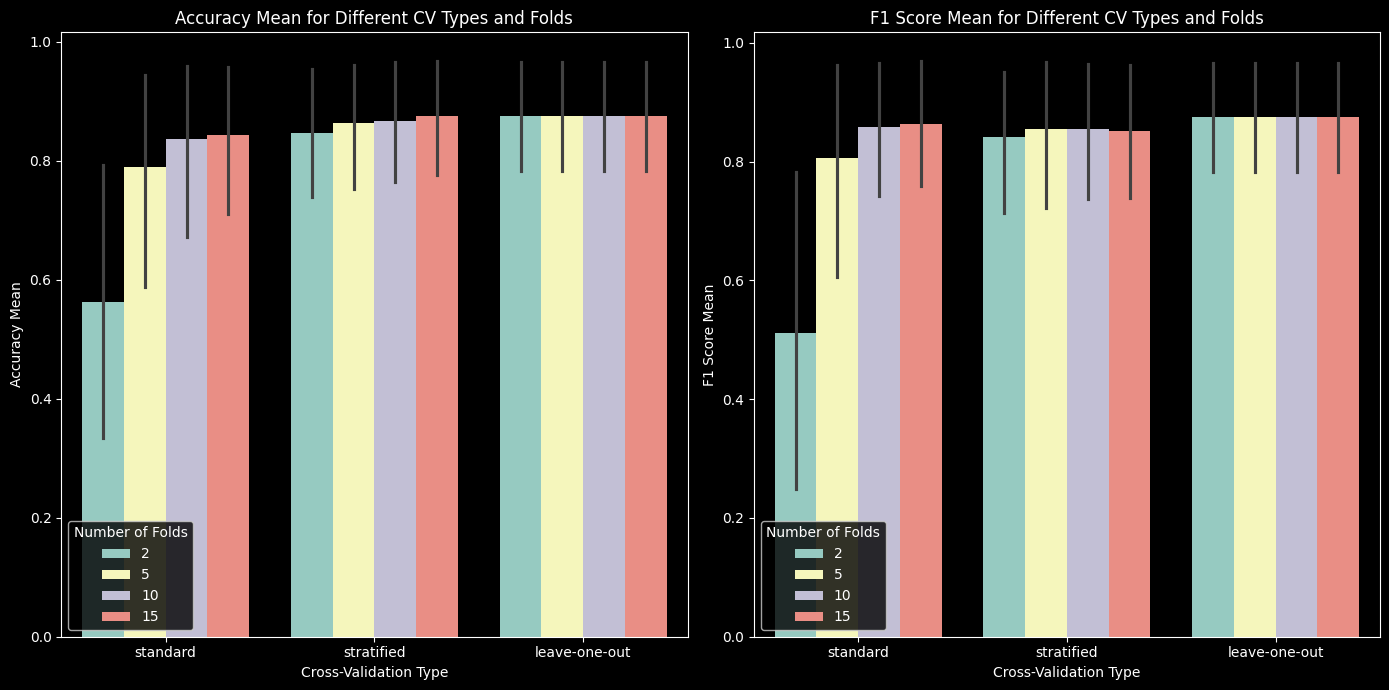

In [13]:
def plot_cross_validation_results(results_df):
    results_df['Folds'] = results_df['Folds'].astype(str)
    results_df['Shuffle'] = results_df['Shuffle'].map({True: 'With Shuffle', False: 'Without Shuffle'})

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    sns.barplot(x='CV Type', y='Accuracy Mean', hue='Folds', data=results_df)
    plt.title('Accuracy Mean for Different CV Types and Folds')
    plt.xlabel('Cross-Validation Type')
    plt.ylabel('Accuracy Mean')
    plt.legend(title='Number of Folds')

    plt.subplot(1, 2, 2)
    sns.barplot(x='CV Type', y='F1 Mean', hue='Folds', data=results_df)
    plt.title('F1 Score Mean for Different CV Types and Folds')
    plt.xlabel('Cross-Validation Type')
    plt.ylabel('F1 Score Mean')
    plt.legend(title='Number of Folds')

    plt.tight_layout()
    plt.show()

plot_cross_validation_results(results_cross_val_df)

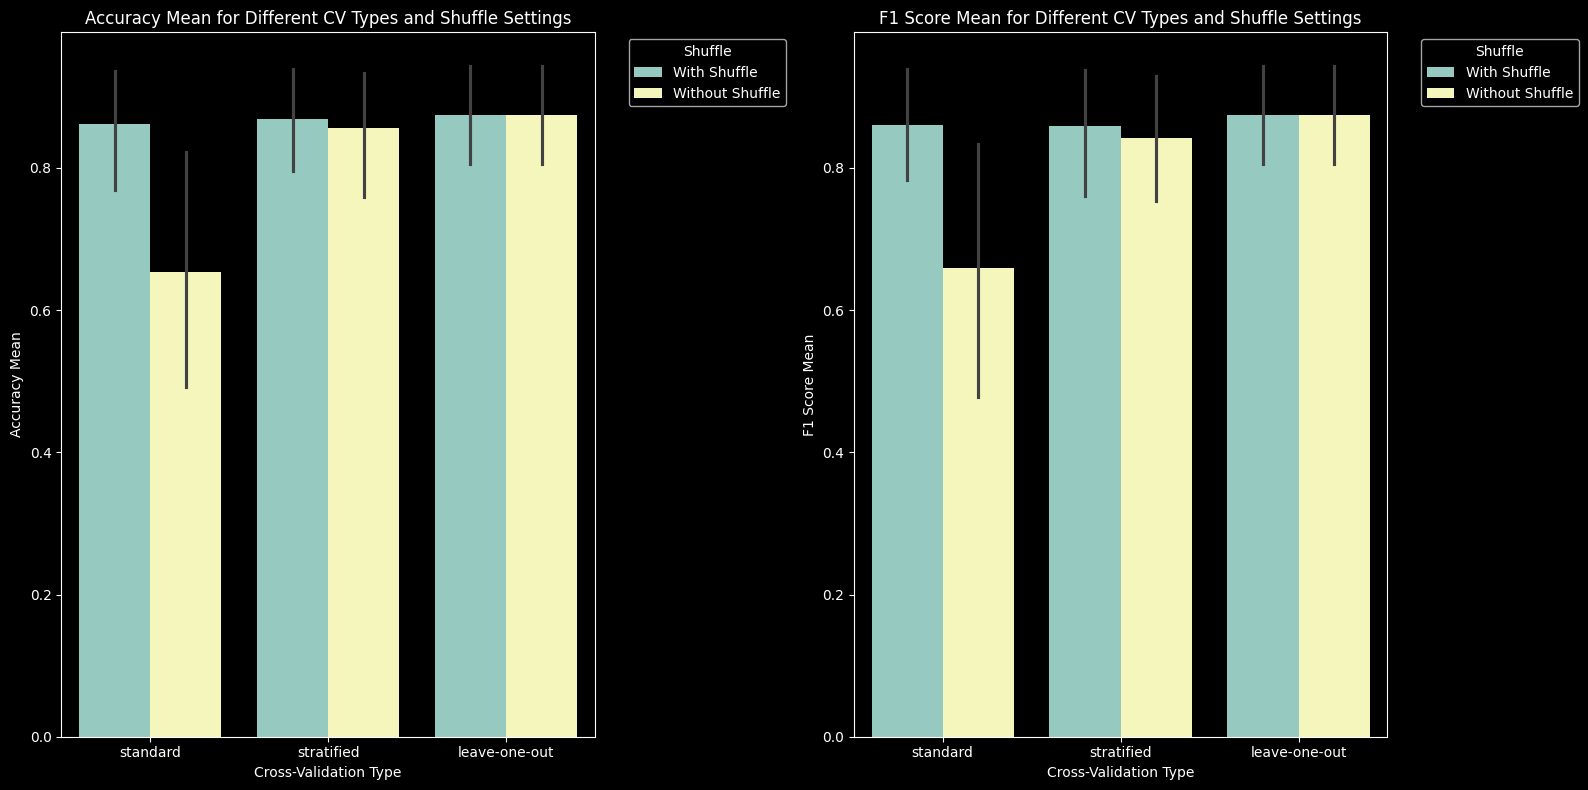

In [14]:
def plot_cross_validation_results_with_shuffle(results_df):
    results_df['Folds'] = results_df['Folds'].astype(str)
    
    results_df['Shuffle'] = results_df['Shuffle'].map({True: 'With Shuffle', False: 'Without Shuffle'})
    
    plt.figure(figsize=(16, 8))
    
    plt.subplot(1, 2, 1)
    sns.barplot(x='CV Type', y='Accuracy Mean', hue='Shuffle', data=results_df)
    plt.title('Accuracy Mean for Different CV Types and Shuffle Settings')
    plt.xlabel('Cross-Validation Type')
    plt.ylabel('Accuracy Mean')
    plt.legend(title='Shuffle', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.subplot(1, 2, 2)
    sns.barplot(x='CV Type', y='F1 Mean', hue='Shuffle', data=results_df)
    plt.title('F1 Score Mean for Different CV Types and Shuffle Settings')
    plt.xlabel('Cross-Validation Type')
    plt.ylabel('F1 Score Mean')
    plt.legend(title='Shuffle', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

results_cross_val_df = pd.DataFrame(all_cross_val_results)
plot_cross_validation_results_with_shuffle(results_cross_val_df)

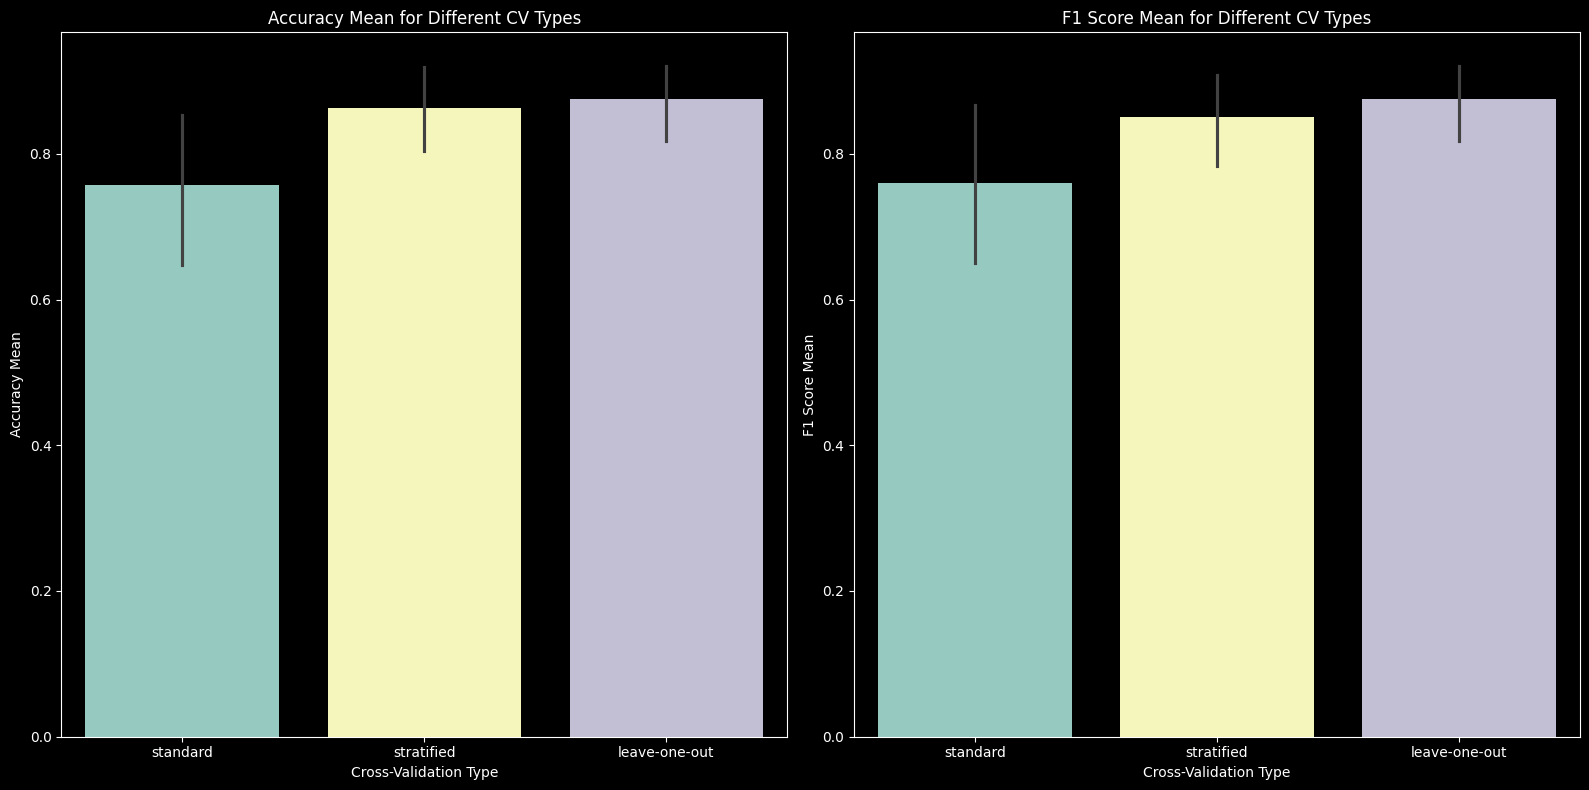

In [15]:
def plot_cross_validation_results_by_cv_type(results_df):
    results_df['Folds'] = results_df['Folds'].astype(str)
    
    results_df['Shuffle'] = results_df['Shuffle'].map({True: 'With Shuffle', False: 'Without Shuffle'})
    
    plt.figure(figsize=(16, 8))
    
    plt.subplot(1, 2, 1)
    sns.barplot(x='CV Type', y='Accuracy Mean', hue='CV Type', data=results_df)
    plt.title('Accuracy Mean for Different CV Types')
    plt.xlabel('Cross-Validation Type')
    plt.ylabel('Accuracy Mean')

    plt.subplot(1, 2, 2)
    sns.barplot(x='CV Type', y='F1 Mean', hue='CV Type', data=results_df)
    plt.title('F1 Score Mean for Different CV Types')
    plt.xlabel('Cross-Validation Type')
    plt.ylabel('F1 Score Mean')
    
    plt.tight_layout()
    plt.show()

results_cross_val_df = pd.DataFrame(all_cross_val_results)
plot_cross_validation_results_by_cv_type(results_cross_val_df)